In [42]:
import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers
import pandas as pd
import matplotlib.pyplot as plt

     pcost       dcost       gap    pres   dres
 0:  4.6555e+01 -3.1972e+03  5e+03  2e-01  7e-15
 1: -1.4972e+01 -5.0032e+02  5e+02  1e-02  7e-15
 2: -1.0285e+02 -2.3053e+02  1e+02  2e-03  8e-15
 3: -1.2075e+02 -2.0866e+02  9e+01  9e-04  8e-15
 4: -1.3890e+02 -1.7362e+02  3e+01  3e-04  9e-15
 5: -1.4375e+02 -1.6323e+02  2e+01  4e-05  1e-14
 6: -1.4832e+02 -1.5417e+02  6e+00  3e-15  1e-14
 7: -1.5016e+02 -1.5119e+02  1e+00  2e-14  1e-14
 8: -1.5059e+02 -1.5063e+02  4e-02  3e-14  1e-14
 9: -1.5061e+02 -1.5061e+02  1e-03  1e-14  1e-14
10: -1.5061e+02 -1.5061e+02  3e-05  1e-14  1e-14
Optimal solution found.


C:\Users\Tyreek ALEXANDER\AppData\Local\Temp\ipykernel_19844\1522638326.py:96: UserWarning: The following kwargs were not used by contour: 'labels'
  plt.contour(X1, X2, Z, [0.0], colors='darkblue', labels='decision boundary')


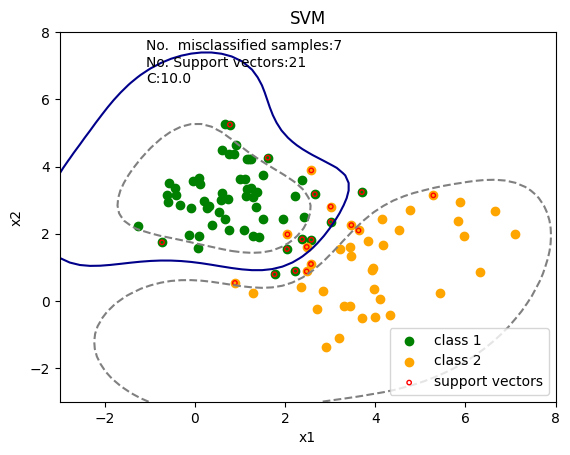

In [44]:
def gaussian_kernel(x, y, sigma=1.75):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

class SVM(object):

    def __init__(self, kernel=gaussian_kernel, C=10.0):
        self.kernel = kernel
        self.C = C

    def fit(self, X, y):
        n_samples= X.shape[0]

        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        G = cvxopt.matrix(np.vstack((np.eye(n_samples)*-1,np.eye(n_samples))))
        h = cvxopt.matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C)))
        A = cvxopt.matrix(y.reshape(1,-1)*1.0)
        b = cvxopt.matrix(0.0)

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        lambdas = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv = lambdas > 0.09999
        ind = np.arange(len(lambdas))[sv]
        self.lambdas = lambdas[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]

        # Offset
        self.b = 0
        for n in range(len(self.lambdas)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.lambdas * self.sv_y * K[ind[n],sv])
        self.b /= len(self.lambdas)
        
        # Weight vector
        self.w = None

    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for lambdas, sv_y, sv in zip(self.lambdas, self.sv_y, self.sv):
                    s += lambdas * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b

    def predict(self, X):
        return np.sign(self.project(X))

if __name__ == "__main__":

    def get_data():
        df=pd.read_excel('proj2dataset.xlsx',header=None)
        df=df.set_axis(['x1', 'x2', 'class'], axis='columns')
        c1=df.where(df['class']==1).dropna()[['x1','x2']].values
        c2=df.where(df['class']==-1).dropna()[['x1','x2']].values
        y=df[['class']].values
        return c1, y[:len(c1)], c2, y[len(c1):]

    def split_train(X1, y1, X2, y2):
        X_train = np.vstack((X1, X2))
        y_train = np.hstack((y1.flatten(), y2.flatten()))
        return X_train, y_train

    def split_test(X1, y1, X2, y2):
        X_test = np.vstack((X1, X2))
        y_test = np.hstack((y1.flatten(), y2.flatten()))
        return X_test, y_test

    
    def plot_contour(X1_train, X2_train, clf):
        
        plt.scatter(X1_train[:,0], X1_train[:,1], c='green',label='class 1')
        plt.scatter(X2_train[:,0], X2_train[:,1], c='orange', label='class 2')
        
        # support vectors
        plt.scatter(clf.sv[:,0], clf.sv[:,1], s=10, facecolors='none', edgecolors='r',label='support vectors')
        
        X1, X2 = np.meshgrid(np.linspace(-3,8,50), np.linspace(-3,8,50))
        X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
        Z = clf.project(X).reshape(X1.shape)
        plt.contour(X1, X2, Z, [0.0], colors='darkblue', labels='decision boundary')
        plt.contour(X1, X2, Z + 1, [0.0], colors='grey', linestyles='--')
        plt.contour(X1, X2, Z - 1, [0.0], colors='grey', linestyles='--')

        plt.annotate(f'No. Support vectors:{len(clf.sv)} \nC:{clf.C}', xy=(2,4), xycoords='data',
            xytext=(-100,60), textcoords='offset points')
        
        plt.title("SVM")
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.legend(loc="lower right")
        plt.show()

    def test_non_linear():
        X1, y1, X2, y2 = get_data()
        X_train, y_train = split_train(X1, y1, X2, y2)
        X_test, y_test = split_test(X1, y1, X2, y2)

        clf = SVM(gaussian_kernel)
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)

        plt.annotate(f'No.  misclassified samples:{len(y_predict)-correct}', xy=(2,5), xycoords='data',
            xytext=(-100,60), textcoords='offset points')
        
        plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)
        

    test_non_linear()
    
